### Sentences in lists:

In [172]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
from huggingface_hub import login
from sklearn.decomposition import PCA
import math 
from IPython.display import Markdown, display
import pandas as pd
def printmd(string):
    display(Markdown(string))

In [173]:
df = pd.read_csv('only_true_jokes_CSVs/selection/final_clean_jokes_with_rating_and_test_sentences.csv')


In [174]:
df

,sentence,word,explanation,first_new_sentence,second_new_sentence,score
0,the flat earth community has supporters all ar...,globe,A globe is a spherical representation of Earth.,The teacher used a globe in class to demonstr...,The poet wrote about the beauty of the globes...,27.0
1,what do you call a basement full of redditors?...,cellar,A cellar is a room below ground level used fo...,They kept the canned goods in the cellar to p...,The wine was stored in a cellar to age properly.,51.0
2,why did the tennis player get thrown out of hi...,racket,A racket is a sports implement used in games ...,She refused to make a racket in the library w...,He bought a new tennis racket for the tournam...,0.0
3,what do you call a scary horse? a night-mare.,mare,A mare is a female horse.,The mare was known for her speed and agility ...,"In folklore, a mare is said to bring bad drea...",7.0
4,what does dr. oz do when you throw scientific ...,duck,Duck can mean a waterfowl or to lower the hea...,The duck swam across the pond gracefully.,I had to duck to avoid hitting my head on the...,11.0
...,...,...,...,...,...,...
1062,what do you call a dog with no legs and metal ...,sparky,"The word sparky can mean lively or energetic,...",The young boy was known for his sparky nature...,The electrician fixed the issue causing spark...,73.0
1063,how do you make soup golden? you add 24 carrots.,carrots,Carrots refer to the vegetable commonly used ...,Carrots are rich in vitamins and are often in...,The farmer harvested the carrots from the fie...,24.0
1064,what did the blanket say as it fell off the be...,sheet,A sheet is a large rectangular piece of fabri...,I need to buy a clean sheet for the guest room.,The architect designed a sheet of glass to be...,11.0
1065,what do elephants use as a tampons? sheep.,sheep,Sheep are domesticated animals kept for their...,The farmer raised sheep for their wool to mak...,The ancient Greeks often depicted sheep in th...,0.0


In [175]:
len(df)

1067

In [176]:
all_sentences=[]

In [177]:
for i in range(5):
    all_sentences.append([df.iloc[i]['word'].strip(), [
        df.iloc[i]['sentence'].strip(),
        df.iloc[i]['first_new_sentence'].strip(),
        df.iloc[i]['second_new_sentence'].strip()
    ]])

In [178]:
all_sentences

[['globe',
  ['the flat earth community has supporters all around the globe.',
   'The teacher used a globe in class to demonstrate the worlds geography.',
   'The poet wrote about the beauty of the globes nature and landscapes.']],
 ['cellar',
  ['what do you call a basement full of redditors? a wine cellar.',
   'They kept the canned goods in the cellar to preserve them.',
   'The wine was stored in a cellar to age properly.']],
 ['racket',
  ['why did the tennis player get thrown out of his workshop? he was making a racket.',
   'She refused to make a racket in the library while studying.',
   'He bought a new tennis racket for the tournament next week.']],
 ['mare',
  ['what do you call a scary horse? a night-mare.',
   'The mare was known for her speed and agility on the track.',
   'In folklore, a mare is said to bring bad dreams to sleeping individuals.']],
 ['duck',
  ['what does dr. oz do when you throw scientific evidence at his head? ducks like a quack.',
   'The duck swam a

In [179]:
#huggingface_token = ...
login(token=huggingface_token)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")



In [180]:

# Function to extract embeddings from a BERT model
def sentences2embeddings(sentences, verbose = False):
    embeddings_all_sentences = []
    
    # Tokenize and process each sentence
    for sentence in sentences:
        if verbose == True: 
            print("Calculating the embeddings of: ", sentence)
            print()
        inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
        
        # Forward pass through the model
        outputs = model(**inputs, output_hidden_states=True)
    
        # Extract token embeddings from the last hidden layer
        tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
        if verbose == True: 
            print("tokens: ", tokens)
            print()
    
        # Extract embeddings from the last hidden layer
        embeddings = outputs.hidden_states[-1][0]  # Shape: [seq_len, hidden_dim]
    
        token_embeddings_pairs = {}
        for token, embedding in zip(tokens, embeddings):
            # Create the dictionary of token and its embedding
            token_embeddings_pairs[token] = embedding.tolist()
    
        embeddings_all_sentences.append(token_embeddings_pairs)
        
    return embeddings_all_sentences



In [181]:
def vis_points(data):

    x = data[:, 0]
    y = data[:, 1]
    z = data[:, 2]
    
    labels=[]
    for i in range (len(data)):
        labels.append(str(i+1))
    
    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c='b', marker='o')
    for i, label in enumerate(labels):
        ax.text(x[i], y[i], z[i], label, fontsize=10, color='blue')
    
    # Show plot
    plt.show()

In [200]:
# Returns a numpy array with the the embedding vectors of the same word in different sentences
def find_embeddings_word_in_different_sentences(sentences, word, verbose = True):

    # Calculate embeddings of words for each sentence
    embeddings_all_sentences = sentences2embeddings(sentences)
          
    # The space is replaced with "▁" (NOTE: not "_", they are different ASCII codes) so each token of a new word starts with it 
    #word2lookfor = "▁" + word
    word2lookfor = word

    for n in range(len(embeddings_all_sentences)):
        print()
        print ("embeddings sentence", n, ":")
        for key, value in embeddings_all_sentences[n].items():
            print(f"{key}: {value[:3]}")
    
    # the first five numbers of the embedding vectors of the word bank within each sentence
    if verbose == True: 
        print ("The different embedding vectors (first 5 elements) of the word \"" + word + "\"")
        for i in range(len(embeddings_all_sentences)):
            print (embeddings_all_sentences[i][word2lookfor][:5])

    # Put the embeddings of the words in a list of lists:
    embeddings_all_sentences_list = []
    for i in range (len(embeddings_all_sentences)):
        embeddings_all_sentences_list.append(embeddings_all_sentences[i][word2lookfor])
    
    # Convert it to numpy array: 4 lines for 4096 elements each (i.e. the length of the embedding vector of a word)
    embeddings_all_sentences_array = np.array(embeddings_all_sentences_list, dtype='float32')

    return embeddings_all_sentences_array
    




In [201]:
# Reduce dimensionality with PCA to visualise the array in a 3d graph
def array2pca(embeddings_all_sentences_array):

    pca = PCA(n_components=3)
    embeddings_all_sentences_array_pca = pca.fit_transform(embeddings_all_sentences_array)
    return embeddings_all_sentences_array_pca
    

In [202]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))


In [203]:
def show_meaning_distances_euclidean(embeddings_all_sentences_array, word):
    printmd ("**Euclidean distance between embedding vectors of the word \""+word+"\" in sentences:**")
    labels=[]
    for i in range (len(embeddings_all_sentences_array)):
        labels.append(str(i+1))
    
    for i in range (len(embeddings_all_sentences_array)):
        j_list = range(i, len(embeddings_all_sentences_array))
        j_list = [*j_list]
        j_list.remove(i)
        for j in j_list:
            if (i+1==2 and j+1==3) or (i+1==4 and j+1==5):
                printmd(f"**{labels[i]} and {labels[j]}: {np.linalg.norm(embeddings_all_sentences_array[i] - embeddings_all_sentences_array[j]):.2f}**")
            else:
                printmd(f"{labels[i]} and {labels[j]}: {np.linalg.norm(embeddings_all_sentences_array[i] - embeddings_all_sentences_array[j]):.2f}")

In [204]:
def show_meaning_similarities_euclidean(embeddings_all_sentences_array, word):
    epsilon = 0.0001
    printmd ("**Similarity between embedding vectors of the word \""+word+"\" (based on opposite of Euclidean distance) in sentences:**")
    labels=[]
    for i in range (len(embeddings_all_sentences_array)):
        labels.append(str(i+1))
    
    for i in range (len(embeddings_all_sentences_array)):
        j_list = range(i, len(embeddings_all_sentences_array))
        j_list = [*j_list]
        j_list.remove(i)
        for j in j_list:
            euclidean_distance = np.linalg.norm(embeddings_all_sentences_array[i] - embeddings_all_sentences_array[j])
            similarity = 1 / (euclidean_distance + epsilon) *100
            if (i+1==2 and j+1==3) or (i+1==4 and j+1==5):
                printmd(f"**{labels[i]} and {labels[j]}: {similarity:.2f}**")
            else:
                printmd(f"{labels[i]} and {labels[j]}: {similarity:.2f}")



In [205]:
def show_meaning_similarities_cosine(embeddings_all_sentences_array, word):
    printmd ("**Cosine similarity between embedding vectors of the word \""+word+"\" (range: -1 for opposite meaning, +1 for very similar) in sentences:**")
    labels=[]
    for i in range (len(embeddings_all_sentences_array)):
        labels.append(str(i+1))
    
    for i in range (len(embeddings_all_sentences_array)):
        j_list = range(i, len(embeddings_all_sentences_array))
        j_list = [*j_list]
        j_list.remove(i)
        for j in j_list:
            if (i+1==2 and j+1==3) or (i+1==4 and j+1==5):
                printmd(f"**{labels[i]} and {labels[j]}: {math.cos(angle_between(embeddings_all_sentences_array[i], embeddings_all_sentences_array[j])):.2f}**")
            else:
                printmd(f"{labels[i]} and {labels[j]}: {math.cos(angle_between(embeddings_all_sentences_array[i], embeddings_all_sentences_array[j])):.2f}")


In [206]:
def analyse_word_in_sentences(sentences, word):
    # calculate embeddings
    embeddings_all_sentences_array = find_embeddings_word_in_different_sentences(sentences, word)

    # calculate pca for visualization
    embeddings_all_sentences_array_pca = array2pca(embeddings_all_sentences_array)

    # visualize
    vis_points(embeddings_all_sentences_array_pca)

    # calculate distance between points
    show_meaning_similarities_euclidean(embeddings_all_sentences_array, word)
    print ()
    show_meaning_similarities_cosine(embeddings_all_sentences_array, word)

# TEST
## Calculate the distance between the embeddings of the same word in different contexts

**globe**

1 - the flat earth community has supporters all around the globe.
2 - The teacher used a globe in class to demonstrate the worlds geography.
3 - The poet wrote about the beauty of the globes nature and landscapes.


embeddings sentence 0 :
[CLS]: [-0.01402663066983223, 0.1668356955051422, 0.13765527307987213]
the: [-0.6001711487770081, 0.10888228565454483, 0.16632944345474243]
flat: [0.915135383605957, -0.376993864774704, 0.9578389525413513]
earth: [-0.12473676353693008, 0.026187598705291748, 0.4478054642677307]
community: [0.810916006565094, -0.11534718424081802, -0.1709599494934082]
has: [0.3566402196884155, 0.389675498008728, 0.4621482789516449]
supporters: [1.0232963562011719, -0.3055802583694458, 0.02914939448237419]
all: [-0.40507176518440247, 0.36889633536338806, 0.7220349907875061]
around: [-0.66689532995224, 0.2784540355205536, 0.1924590766429901]
globe: [0.33648616075515747, 0.14463874697685242, 0.12018117308616638]
.: [0.5712435841560364, -0.04302891343832016, -0.30083352327

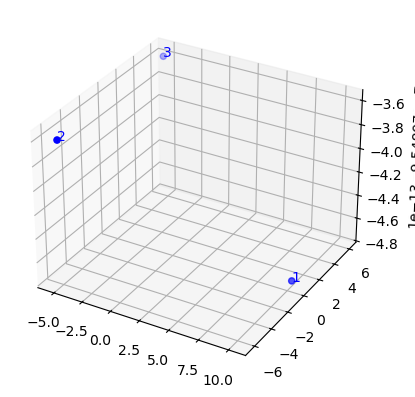

**Similarity between embedding vectors of the word "globe" (based on opposite of Euclidean distance) in sentences:**

1 and 2: 6.08

1 and 3: 6.01

**2 and 3: 8.21**

**Cosine similarity between embedding vectors of the word "globe" (range: -1 for opposite meaning, +1 for very similar) in sentences:**

1 and 2: 0.42

1 and 3: 0.39

**2 and 3: 0.61**

**cellar**

1 - what do you call a basement full of redditors? a wine cellar.
2 - They kept the canned goods in the cellar to preserve them.
3 - The wine was stored in a cellar to age properly.


embeddings sentence 0 :
[CLS]: [0.06809261441230774, 0.06510338932275772, -0.23508992791175842]
what: [0.4997454881668091, -0.10335594415664673, -0.6020895838737488]
do: [0.5563700795173645, 0.0776159018278122, -0.39026227593421936]
you: [0.22084172070026398, -0.3200734853744507, -0.5208382606506348]
call: [0.45796096324920654, 1.1839463710784912, 0.23074239492416382]
a: [-0.11052796989679337, 0.5032063722610474, -0.5015779733657837]
basement: [1.447916865348816, 0.5467675924301147, -0.6169765591621399]
full: [-0.0064870999194681644, 0.05132342129945755, 0.10846252739429474]
of: [0.20893265306949615, 0.2826891541481018, 0.10084649920463562]
red: [0.027002345770597458, -0.8678498268127441, 0.32006213068962097]
##dit: [0.012374290265142918, -0.6839234232902527, 0.7259311676025391]
##ors: [0.6425626277923584

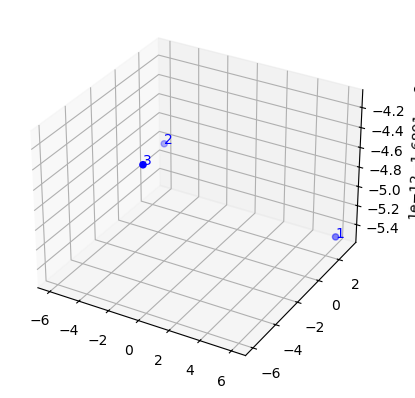

**Similarity between embedding vectors of the word "cellar" (based on opposite of Euclidean distance) in sentences:**

1 and 2: 8.35

1 and 3: 9.26

**2 and 3: 9.28**

**Cosine similarity between embedding vectors of the word "cellar" (range: -1 for opposite meaning, +1 for very similar) in sentences:**

1 and 2: 0.67

1 and 3: 0.71

**2 and 3: 0.74**

**racket**

1 - why did the tennis player get thrown out of his workshop? he was making a racket.
2 - She refused to make a racket in the library while studying.
3 - He bought a new tennis racket for the tournament next week.


embeddings sentence 0 :
[CLS]: [0.04632001370191574, 0.2196321189403534, 0.0835866928100586]
why: [0.24122849106788635, 0.36257708072662354, -0.1198815107345581]
did: [-0.23166169226169586, -0.20463883876800537, 0.24486351013183594]
the: [0.28598394989967346, -0.193523108959198, -0.05152513459324837]
tennis: [-0.0718512013554573, -0.39528965950012207, 0.3190123736858368]
player: [-0.02802019938826561, 0.0016218069940805435, 0.3016454875469208]
get: [-0.10142872482538223, -0.3048568069934845, 0.5175058841705322]
thrown: [0.08487526327371597, -0.033391933888196945, 0.05685975402593613]
out: [-0.5059062838554382, -0.40975868701934814, -0.19772092998027802]
of: [-0.8624881505966187, -0.05314107611775398, -0.3213236331939697]
his: [0.4180920422077179, 0.4595106840133667, 0.29114

KeyError: 'racket'

In [207]:
for sentences_group in all_sentences:
    word = sentences_group[0]
    printmd ("**"+word+"**")
    sentences = sentences_group[1]
    for i, sentence in enumerate(sentences):
        print (i+1, "-", sentence)
    print ()
    analyse_word_in_sentences(sentences, word)
    print ()